# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [14]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [15]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC2997/NGC2997_V.fits')
data = hdu['PRIMARY'].data

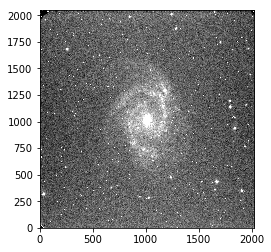

In [16]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)

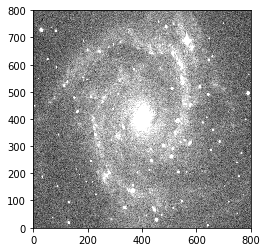

In [17]:
#cut
from astropy.nddata import Cutout2D
position = (1010, 1003)
size=(800,800)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [18]:
data_properties?

In [19]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

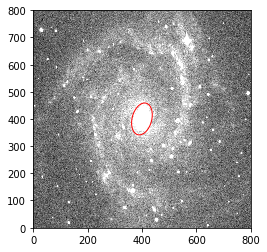

In [20]:
# how does it look?
geometry = EllipseGeometry (x0=400, y0=400, sma=60, eps=0.6,pa=75*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [21]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [22]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,55.20935910578058,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5111130767700377,54.72094636335242,0.024351448123236696,0.5366939337482558,0.01782882289571686,90.7439447145,1.39105569875,0.5399464493155353,13,0,10,0
0.5622243844470415,54.64799790039065,0.028024874507132442,0.5299518482010733,0.018516114196582042,90.9710559442,1.45303581035,0.5539272580813203,13,0,10,0
0.6184468228917457,54.56417243525938,0.03260642952407517,0.5210354102252853,0.01950561136314583,91.2232970933,1.5485289846,0.5727714425878131,13,0,10,0
0.6802915051809203,54.469239656407886,0.03827718300919805,0.5108618623345859,0.020722564525933143,91.5220849801,1.66696573059,0.596533985475745,13,0,10,0
0.7483206556990124,54.362546439599434,0.04530637092291316,0.5000159582177208,0.022184028287199196,91.8863983979,1.80624774384,0.6257589958292452,13,0,10,0
0.8231527212689137,54.24246876520741,0.05331365355980856,0.4890854431673988,0.02340880688283465,92.1491861232,1.93826772096,0.6450551901231159,13,0,10,0
0.9054679933958051,54.10963683187779,0.062198634780605305,0.47949406334682015,0.022851283199050932,92.3562405783,1.91841108184,0.607093826984881,13,0,10,0


Text(0,0.5,'Ellipticity')

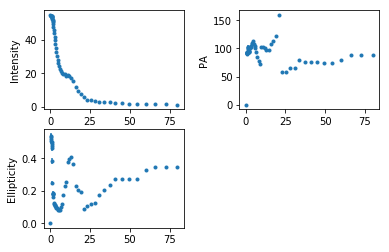

In [23]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [24]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

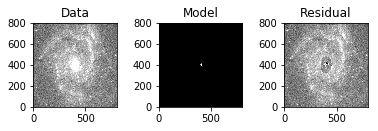

In [25]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', vmin=16, vmax=20)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', vmin=16, vmax=20)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', vmin=16, vmax=20)
ax3.set_title('Residual')

In [26]:
cutout.data

array([[17.904314, 17.424109, 18.218927, ..., 18.189936, 18.335066,
        18.620531],
       [17.850145, 17.619802, 17.049988, ..., 17.756903, 18.21741 ,
        18.012661],
       [17.20751 , 17.836355, 17.48718 , ..., 17.959875, 18.000162,
        17.559998],
       ...,
       [17.149042, 17.587244, 18.512695, ..., 17.99305 , 17.779224,
        17.799555],
       [17.98196 , 17.311922, 17.928762, ..., 17.742193, 17.14814 ,
        17.816133],
       [17.03715 , 17.69611 , 17.228767, ..., 17.67713 , 17.598856,
        17.872488]], dtype=float32)